<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 74 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), 3.58 MiB | 3.18 MiB/s, done.
/content/autoencoders_census


In [2]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb
import import_ipynb
from pandas2vector import DataTransformer
from data_loader import DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [6]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [7]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [8]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, variable_types = data_loader.prepare_original_dataset(original_df)



In [9]:
original_df.shape

(14765, 305)

In [10]:
project_data.shape

(14765, 108)

# Transforming the original data set

## Dropping uneccessary columns

We only reserve columns of questionnaire questions and other necessary information such as students' height, students' weight, age, sex, etc. The first 89 questionnaire questions and other columns (weight, age, sex, grade, race, student height, student weight, BMI, BMI percentage, obese, overweight) are in the first 100 columns.

Our dataset contains 14765 observations and 110 raw features.

In [11]:
# Data Transformation
data_transformer = DataTransformer(variable_types)
project_data_missing = data_transformer.add_missing_indicators(project_data)
transformed_df = data_transformer.transform_dataframe(project_data_missing)


In [12]:
transformed_df.shape

(14765, 774)

## Code that transforms a dataframe to vector format and vice versa




# Autoencoder training

## Architecture setup

In [ ]:
latent_dimension = 1
batch_size = 20

hidden_nodes = 16

# The dimensionality of the dataframe is (nrows x dim).
# We keep the dim as the size of the input
input_dim = transformed_df.shape[1]

input_encoder = Input(shape=(input_dim,), name="Input_Encoder")

batch_normalize1 = BatchNormalization()(input_encoder)

hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)

z = Dense(latent_dimension, name="Mean")(batch_normalize2)

Define and create the encoder model.

In [ ]:
encoder = Model(input_encoder, z, name="Encoder")

Define the decoder part of the autoencoder model. It's responsible for reconstructing the original input data from the compressed representation.

In [ ]:
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)

decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)

decoded = Dense(input_dim, activation="linear", name="Decoded")(batch_normalize2)

In [ ]:
decoder = Model(input_decoder, decoded, name="Decoder")

Combine the encoder and decoder models to create the complete autoencoder architecture.

In [ ]:
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)

ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Encoder (InputLayer)  [(None, 774)]             0         
                                                                 
 Encoder (Functional)        (None, 1)                 15577     
                                                                 
 Decoder (Functional)        (None, 774)               13258     
                                                                 
Total params: 28,835
Trainable params: 27,221
Non-trainable params: 1,614
_________________________________________________________________


## Train the Model

The training of an autoencoder model while effectively handling missing data with mask variables.

In [ ]:
mask = np.where(transformed_df.isnull(), 0.0, 1.0)
mask = np.expand_dims(mask, axis=-1)

def masked_mse(y_true, y_pred):
    mask = tf.where(tf.math.is_nan(y_true), 0.0, 1.0)
    return tf.reduce_mean(tf.square(y_true - y_pred) * mask)

ae.compile(loss=masked_mse, optimizer="adam", weighted_metrics=[])

# Replace null values in the dataframe with zeros
transformed_df = transformed_df.fillna(0.0)

# Initialize lists to track losses
train_loss = []
val_loss = []

class LossTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss.append(logs.get('loss'))
        val_loss.append(logs.get('val_loss'))

loss_tracker = LossTracker()

history = ae.fit(
    transformed_df, transformed_df, sample_weight=mask, shuffle=True, epochs=10, batch_size=20,
    validation_split=0.2, verbose=0, callbacks=[loss_tracker]
)

Hyperparameter Tuning

In [ ]:
! pip install keras-tuner
from kerastuner.tuners import RandomSearch

In [ ]:
transformed_df = transformed_df.fillna(0.0)
X_train, X_test = train_test_split(transformed_df, test_size=0.2, random_state=42)

input_shape = X_train.shape[1:]
d = 5

# Define the encoder model
def build_encoder(hp):
    inputs = Input(shape=input_shape)
    x = Dense(units=hp.Int('encoder_units_1', min_value=32, max_value=256, step=32), activation='relu')(inputs)
    x = Dense(units=hp.Int('encoder_units_2', min_value=16, max_value=128, step=16), activation='relu')(x)
    latent_space = Dense(units=d, activation='relu')(x)
    encoder = Model(inputs, latent_space)
    return encoder

# Define the decoder model
def build_decoder(hp):
    decoder_inputs = Input(shape=(d,))
    x = Dense(units=hp.Int('decoder_units_1', min_value=16, max_value=128, step=16), activation='relu')(decoder_inputs)
    x = Dense(units=hp.Int('decoder_units_2', min_value=32, max_value=256, step=32), activation='relu')(x)
    outputs = Dense(units=input_shape[0], activation='linear')(x)
    decoder = Model(decoder_inputs, outputs)
    return decoder

# Define the autoencoder model by combining the encoder and decoder models
def build_autoencoder(hp):
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)
    autoencoder_input = Input(shape=input_shape)
    encoder_output = build_encoder(hp)(autoencoder_input)
    decoder_output = build_decoder(hp)(encoder_output)
    autoencoder = Model(autoencoder_input, decoder_output)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return autoencoder

# Define the tuner
tuner = RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='HDHyperparameter',
    overwrite=True,
    seed=42)

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = build_autoencoder(best_hps)

train_loss1 = []
val_loss1 = []

# Train the final model
history1 = final_model.fit(X_train, X_train,
                          epochs=10,
                          batch_size=32,
                          verbose=1,
                          validation_data=(X_test, X_test))


Trial 10 Complete [00h 01m 00s]
val_loss: 0.04833012322584788

Best val_loss So Far: 0.04721990848580996
Total elapsed time: 00h 11m 21s
Epoch 1/10
370/370 [==============================] - 3s 6ms/step - loss: 0.0650 - val_loss: 0.0563
Epoch 2/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0555 - val_loss: 0.0540
Epoch 3/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0538 - val_loss: 0.0528
Epoch 4/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0522 - val_loss: 0.0508
Epoch 5/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0499 - val_loss: 0.0488
Epoch 6/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0486 - val_loss: 0.0478
Epoch 7/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0476 - val_loss: 0.0470
Epoch 8/10
370/370 [==============================] - 2s 5ms/step - loss: 0.0470 - val_loss: 0.0467
Epoch 9/10
370/370 [==============================] - 2s 5ms/st

In [ ]:
final_model.get_config()

{'name': 'model_5',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 774),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_4'},
   'name': 'input_4',
   'inbound_nodes': []},
  {'class_name': 'Functional',
   'config': {'name': 'model_3',
    'trainable': True,
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 774),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_5'},
      'name': 'input_5',
      'inbound_nodes': []},
     {'class_name': 'Dense',
      'config': {'name': 'dense_6',
       'trainable': True,
       'dtype': 'float32',
       'units': 128,
       'activation': 'relu',
       'use_bias': True,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        'config': {'seed': None}},
       'bias_initializer': {'class_name': 'Zeros', 'config': {}},
       'kernel_regularizer': None,
       

In [ ]:
train_loss1.append(history1.history['loss'][-1])
val_loss1.append(history1.history['val_loss'][-1])

# Save the model as a .h5 file
model_filename = "Hyperparameter.h5"
final_model.save(model_filename)

# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"learning_rate": best_hps.get('learning_rate'),
                        "batch_size": best_hps.get('batch_size'),
                        "num_epochs": 10,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}

## Examine Training Output Statistics

Visualize the training and validation loss values over epochs.

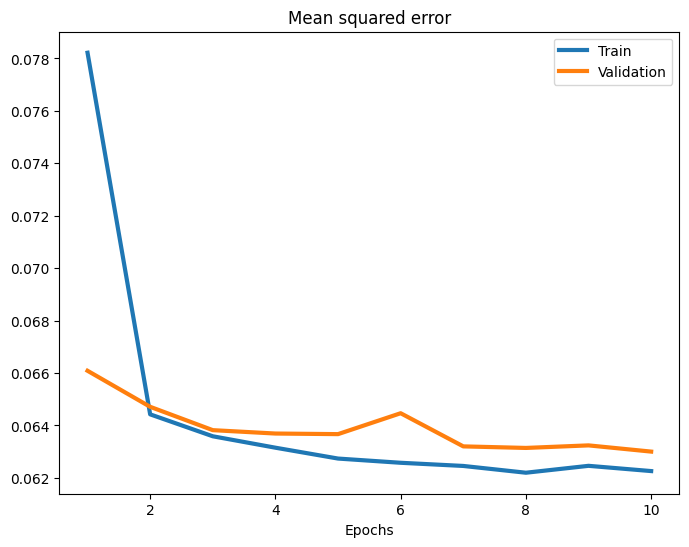

Training MSE = 0.24951699656299992
Validation MSE = 0.2510012454946172


In [ ]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(train_loss, val_loss)

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

462/462 [==============================] - 1s 1ms/step


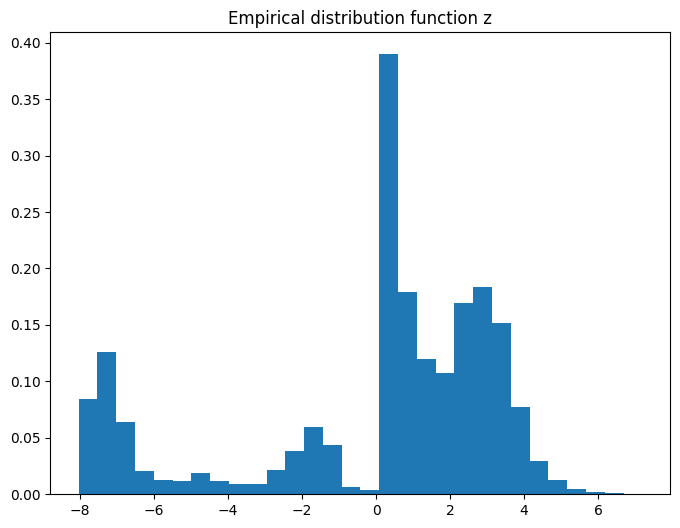

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14))
# use the encoder model to obtain the latent representation (z) of the data input
plt.hist(encoder.predict(transformed_df), bins=30, density=True)
plt.savefig("DistInternal.png", dpi=400)

In [ ]:
ae.predict(transformed_df)[0,:]

Visualize the empirical cumulative distribution function (ECDF) of the first dimension of the latent representation obtained from the encoder model.

462/462 [==============================] - 1s 2ms/step


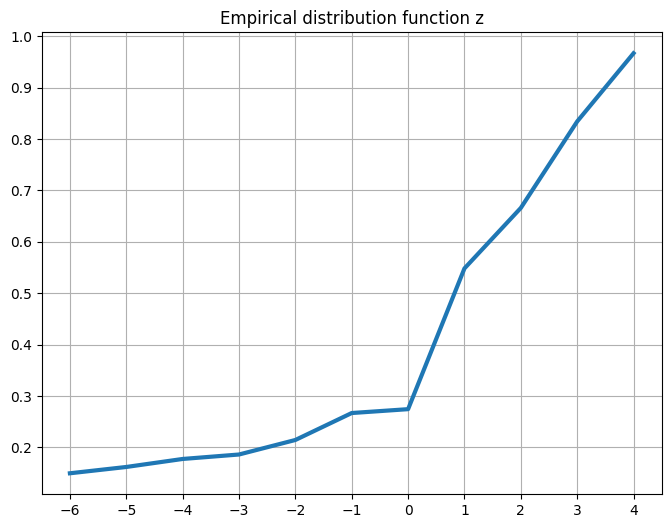

In [ ]:
ecdf = ECDF(encoder.predict(transformed_df)[:, 0])
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

Visualize the inverted empirical distribution function based on the sample EDF values and their corresponding x-values.

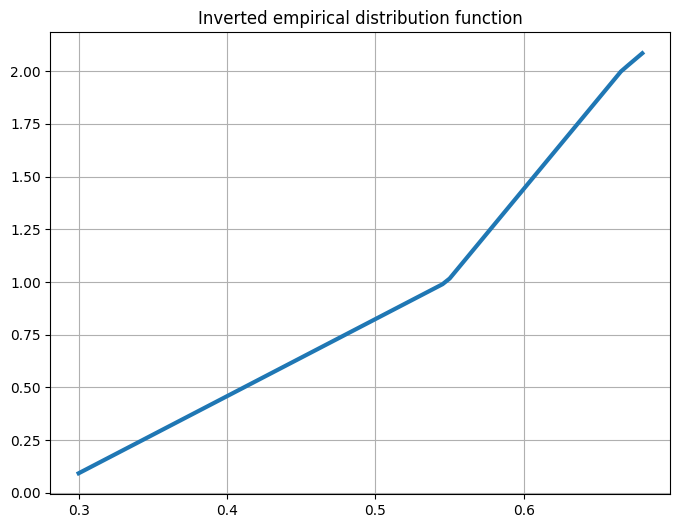

In [ ]:
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
# calculate the sample EDF values at the specified x-values
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Inverted empirical distribution function")
x = np.linspace(0.30, 0.68, 80)
plt.xticks(np.linspace(0, 1.0, 11))
plt.grid()
plt.plot(x, inverted_edf(x), linewidth=3)
plt.savefig("InvertedEmpiricalDF.png", dpi=400)

Generate random values from a specific distribution that resembles the original data distribution using the inverted empirical distribution function.

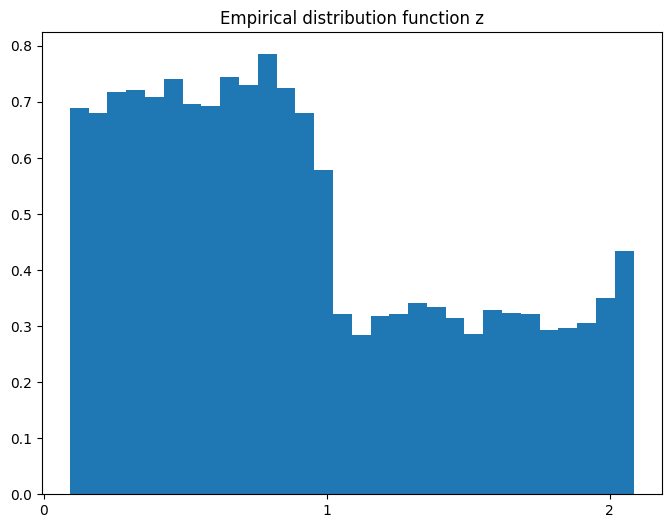

In [ ]:
# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-5, -4, -3, -2, -1, 0, 1, 2, 3, 4))
# N random values from a uniform distribution are transformed to follow a specific distribution using the inverted EDF
plt.hist(inverted_edf(uniform(0.30, 0.68, N)), bins=30, density=True)
plt.savefig("DistGenerated.png", dpi=400)

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 2ms/step


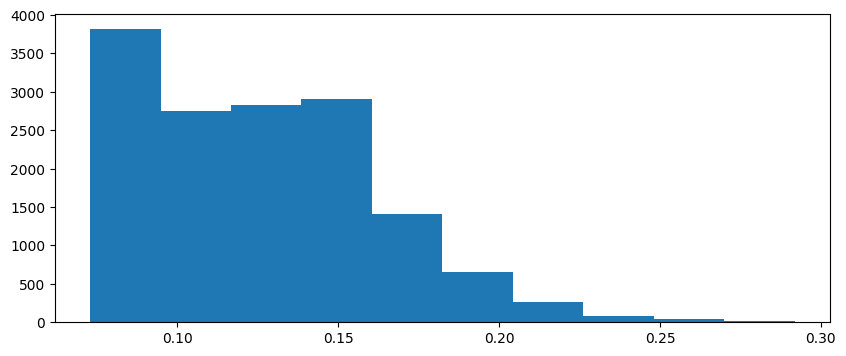

In [ ]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = ae.predict(transformed_df)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions, transformed_df)
plt.hist(normal_loss, bins=10)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [ ]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.19833917991126063


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

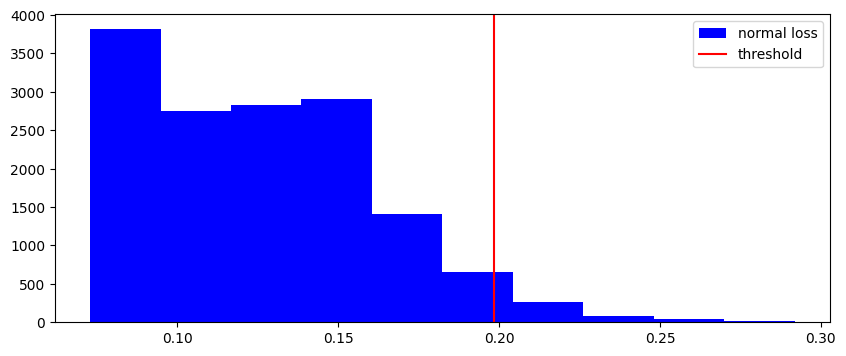

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=10, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [ ]:
normal_loss

<tf.Tensor: shape=(14765,), dtype=float64, numpy=
array([0.16839831, 0.13835383, 0.19082037, ..., 0.19372659, 0.10854131,
       0.21165806])>

In [ ]:
reconstructed_error_df = pd.DataFrame()
reconstructed_error_df['Reconstructed_Error'] = normal_loss
reconstructed_error_df.to_csv('data_with_reconstructed_errors.csv', index=False)
reconstructed_error_df.head()

,Reconstructed_Error
0,0.168398
1,0.138354
2,0.190820
3,0.200023
4,0.163826


Obtain the indices in descending order of the reconstruction errors.

In [ ]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [ ]:

k = 100  # Number of samples to select
samples_with_high_error = transformed_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
10746,0.171619,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100,0.055313,0.000000,0.000000,0.140038,0.000000,0,0,1,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9181,0.155655,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
7757,0.158000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5831,0.104752,0.535211,0.188926,0.085192,0.123637,0,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = transformed_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
3,0.161873,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.356232,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12,0.211872,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
15,0.043351,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18,0.396248,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
anomaly_tuples.shape

(511, 774)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [ ]:
ae.compile(loss="mean_squared_error", optimizer="adam")

reconstructed_data = ae.predict(transformed_df)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)

columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
transformed_df[columns_to_modify] = transformed_df[columns_to_modify].replace(0, np.nan)

combined_df = pd.concat([transformed_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,0.508875,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.073574,-0.011989,0.622469,0.395902,-0.010063,0.034001,0.022694,0.822259,0.145681,-0.008314
1,0.347927,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.072677,0.029253,0.692635,0.261063,0.045464,0.003265,0.020947,0.811055,0.128486,0.037601
2,0.142144,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.072180,-0.015729,0.558282,0.454608,-0.014722,0.057626,0.022999,0.788158,0.159457,-0.006930
3,0.161873,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.071324,-0.018027,0.518842,0.490680,-0.017585,0.072142,0.023186,0.767204,0.167921,-0.006080
4,0.415955,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.030209,0.769667,0.249821,0.046002,0.765051,-0.008666,0.009436,0.252173,0.025400,0.738532


In [ ]:
reconstructed_data1 = final_model.predict(transformed_df)
reconstructed_df1 = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)
columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
transformed_df[columns_to_modify] = transformed_df[columns_to_modify].replace(0, np.nan)

reconstructed_df1.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,0.243521,0.487967,0.257393,0.092425,0.566172,0.001605,0.014359,0.008653,0.005616,0.022474,...,0.073574,-0.011989,0.622469,0.395902,-0.010063,0.034001,0.022694,0.822259,0.145681,-0.008314
1,0.240623,0.458117,0.223996,0.089072,0.542006,0.000386,0.004247,0.003312,0.004379,0.012389,...,0.072677,0.029253,0.692635,0.261063,0.045464,0.003265,0.020947,0.811055,0.128486,0.037601
2,0.250088,0.495230,0.270631,0.091660,0.568362,0.002327,0.017022,0.012719,0.011244,0.020699,...,0.072180,-0.015729,0.558282,0.454608,-0.014722,0.057626,0.022999,0.788158,0.159457,-0.006930
3,0.254123,0.499693,0.278764,0.091191,0.569709,0.002771,0.018657,0.015218,0.014702,0.019608,...,0.071324,-0.018027,0.518842,0.490680,-0.017585,0.072142,0.023186,0.767204,0.167921,-0.006080
4,0.206245,0.487219,0.222384,0.091701,0.565774,-0.000235,0.004138,0.005335,0.011341,0.039120,...,0.030209,0.769667,0.249821,0.046002,0.765051,-0.008666,0.009436,0.252173,0.025400,0.738532


Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [ ]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

<ipython-input-52-9a1a964cdb25>:9: RuntimeWarning: divide by zero encountered in double_scalars
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)


In [ ]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost1 = {}
mapped_categories1 = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost1[column] = cost_value

for column, cost in cost1.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories1[column] = (reconstructed_df1[column] > cost).astype(int)

<ipython-input-53-fafba6672185>:9: RuntimeWarning: divide by zero encountered in double_scalars
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)


Evaluate the performance of the reconstructed categories compared to the original dataset. A higher AUC score indicates better performance in distinguishing different instances.

In [ ]:
auc_scores = {}

for column in mapped_categories:

    mapped_values = mapped_categories[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


{'weight_missing': nan,
 'age_missing': 0.5,
 'sex_missing': 0.5,
 'grade_missing': 0.5,
 'Hispanic or Latino_missing': 0.5,
 'race_missing': 0.5,
 'stheight_missing': 0.5271925870400059,
 'stweight_missing': 0.52766267228119,
 'bmi_missing': 0.5274727884782676,
 'bmipct_missing': 0.5277143793084687,
 'obese_missing': 0.5277098217604033,
 'overweight_missing': 0.527548569131943,
 'sexual identity_missing': 0.6944105679215653,
 'sex/sexual contacts_missing': 0.7090584454966584,
 'sexid_missing': 0.69623482946731,
 'sexid2_missing': 0.6924669833366347,
 'sexpart_missing': 0.6727990947360163,
 'sexpart2_missing': 0.6602887355977122,
 'seat belt use_missing': 0.9083013169468163,
 'riding with a drinking driver_missing': 0.5,
 'drinking and driving_missing': 0.5142445738774981,
 'texting and driving_missing': 0.5046123689991503,
 'weapon carrying_missing': 0.9393910955205614,
 'weapon carrying at school_missing': 0.5,
 'gun carrying past 12 mos_missing': 0.8620366078987536,
 'safety concern

In [ ]:
from sklearn.metrics import confusion_matrix

num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = mapped_categories[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[14765]]

Confusion Matrix for age_missing:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_missing:
[[14638     0]
 [  127     0]]

Confusion Matrix for grade_missing:
[[14621     0]
 [  144     0]]

Confusion Matrix for Hispanic or Latino_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for race_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for stheight_missing:
[[ 2006 11140]
 [  159  1460]]

Confusion Matrix for stweight_missing:
[[ 1994 11152]
 [  156  1463]]

Confusion Matrix for bmi_missing:
[[ 2064 11142]
 [  158  1401]]

Confusion Matrix for bmipct_missing:
[[ 1971 11175]
 [  153  1466]]

Confusion Matrix for obese_missing:
[[ 1979 11167]
 [  154  1465]]

Confusion Matrix for overweight_missing:
[[ 1991 11155]
 [  156  1463]]

Confusion Matrix for sexual identity_missing:
[[13538   570]
 [  375   282]]

Confusion Matrix for sex/sexual contacts_missing:
[[4992 6405]
 [  67 3301]]

Confusion Matrix for sexid_mis

In [ ]:
merged_df = (pd.DataFrame(mapped_categories)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df.head(10)

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.243521,0.487967,0.257393,0.092425,0.566172
1,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,1,0.240623,0.458117,0.223996,0.089072,0.542006
2,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250088,0.495230,0.270631,0.091660,0.568362
3,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.254123,0.499693,0.278764,0.091191,0.569709
4,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.206245,0.487219,0.222384,0.091701,0.565774
5,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.244041,0.488543,0.258442,0.092364,0.566346
6,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250461,0.495644,0.271384,0.091617,0.568487
7,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.249093,0.494131,0.268627,0.091776,0.568031
8,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.240214,0.466383,0.232188,0.090327,0.549461
9,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.204632,0.483778,0.221751,0.090718,0.561330


In [ ]:
merged_df1 = (pd.DataFrame(mapped_categories1)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df1.head(10)

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.243521,0.487967,0.257393,0.092425,0.566172
1,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,1,0.240623,0.458117,0.223996,0.089072,0.542006
2,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250088,0.495230,0.270631,0.091660,0.568362
3,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.254123,0.499693,0.278764,0.091191,0.569709
4,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.206245,0.487219,0.222384,0.091701,0.565774
5,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.244041,0.488543,0.258442,0.092364,0.566346
6,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250461,0.495644,0.271384,0.091617,0.568487
7,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.249093,0.494131,0.268627,0.091776,0.568031
8,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.240214,0.466383,0.232188,0.090327,0.549461
9,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.204632,0.483778,0.221751,0.090718,0.561330


\#2 approach for getting cost values:

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories_z_score = {}

cost_df = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories_z_score[column] = mapped_values

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories2 = {}

cost_df2 = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df2[column] = cost_values

    cost_df2.head()

for column, cost in cost_df2.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df1[column] > lower_bound) & (reconstructed_df1[column] < upper_bound)).astype(int)
    mapped_categories2[column] = mapped_values

In [ ]:
mapped_values_df = pd.DataFrame(mapped_categories2)
true_labels_df = transformed_df[categorical_vars]
fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9986846688726954

In [ ]:
predicted_labels = mapped_values_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[9649345,   14765],
       [   1864, 1688311]])

In [ ]:
numeric_vars = ["weight", "stheight", "stweight", "bmi", "bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

best_auc_score = None
best_std_multiplier = None
best_mapped_categories = None

for std_multiplier in np.arange(0.5, 7.1, 0.1):  # Try different values of std_multiplier from 1.0 to 7.0
    cost_df = pd.DataFrame()

    for column in transformed_df[categorical_vars]:
        probability = transformed_df[column].mean(axis=0)
        std = transformed_df[column].std(axis=0)

        cost_values = []
        for index, value in transformed_df[column].items():
            cost_value = (value - probability) / (std_multiplier * std) if std != 0 else np.inf
            cost_values.append(cost_value)

        cost_df[column] = cost_values

    # Apply the cost_df to the reconstructed_df to calculate mapped_values
    mapped_categories = {}
    for column, cost in cost_df.items():
        lower_bound = transformed_df[column].mean(axis=0) - cost
        upper_bound = transformed_df[column].mean(axis=0) + cost
        mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
        mapped_categories[column] = mapped_values

    # Calculate the AUC score for the whole DataFrame
    mapped_values_df = pd.DataFrame(mapped_categories)
    true_labels_df = transformed_df[categorical_vars]
    fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
    roc_auc = auc(fpr, tpr)

    # Check if the current AUC score is better than the previous best AUC score
    if best_auc_score is None or roc_auc > best_auc_score:
        best_auc_score = roc_auc
        best_std_multiplier = std_multiplier
        best_mapped_categories = mapped_categories


In [ ]:
print("Best std multiplier:", best_std_multiplier)
print("Best AUC score:", best_auc_score)

Best std multiplier: 0.5
Best AUC score: 0.9992360910627053


In [ ]:
auc_scores = {}

for column in mapped_categories2:

    mapped_values = mapped_categories2[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


{'weight_missing': nan,
 'age_missing': 1.0,
 'sex_missing': 1.0,
 'grade_missing': 1.0,
 'Hispanic or Latino_missing': 1.0,
 'race_missing': 1.0,
 'stheight_missing': 1.0,
 'stweight_missing': 1.0,
 'bmi_missing': 1.0,
 'bmipct_missing': 1.0,
 'obese_missing': 1.0,
 'overweight_missing': 1.0,
 'sexual identity_missing': 1.0,
 'sex/sexual contacts_missing': 1.0,
 'sexid_missing': 1.0,
 'sexid2_missing': 1.0,
 'sexpart_missing': 1.0,
 'sexpart2_missing': 1.0,
 'seat belt use_missing': 1.0,
 'riding with a drinking driver_missing': 1.0,
 'drinking and driving_missing': 1.0,
 'texting and driving_missing': 1.0,
 'weapon carrying_missing': 1.0,
 'weapon carrying at school_missing': 1.0,
 'gun carrying past 12 mos_missing': 1.0,
 'safety concerns at school_missing': 1.0,
 'threatened at school_missing': 1.0,
 'physical fighting_missing': 1.0,
 'physical fighting at school_missing': 1.0,
 'forced sexual intercourse_missing': 1.0,
 'sexual violence_missing': 1.0,
 'sexual dating violence_miss

In [ ]:
num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = mapped_categories2[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[    0 14765]
 [    0     0]]

Confusion Matrix for age_missing:
[[14684     0]
 [    0    81]]

Confusion Matrix for sex_missing:
[[14638     0]
 [    0   127]]

Confusion Matrix for grade_missing:
[[14621     0]
 [    0   144]]

Confusion Matrix for Hispanic or Latino_missing:
[[14428     0]
 [    0   337]]

Confusion Matrix for race_missing:
[[14428     0]
 [    0   337]]

Confusion Matrix for stheight_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for stweight_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for bmi_missing:
[[13206     0]
 [    0  1559]]

Confusion Matrix for bmipct_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for obese_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for overweight_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for sexual identity_missing:
[[14108     0]
 [    0   657]]

Confusion Matrix for sex/sexual contacts_missing:
[[11397     0]
 [    0  3368]]

Confu

In [ ]:
merged_df1 = (reconstructed_df[numeric_vars]).merge((pd.DataFrame(mapped_categories2)), left_index = True, right_index = True)
merged_df1.head(10)

,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,0.243521,0.487967,0.257393,0.092425,0.566172,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
1,0.240623,0.458117,0.223996,0.089072,0.542006,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,0.250088,0.495230,0.270631,0.091660,0.568362,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
3,0.254123,0.499693,0.278764,0.091191,0.569709,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
4,0.206245,0.487219,0.222384,0.091701,0.565774,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1
5,0.244041,0.488543,0.258442,0.092364,0.566346,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
6,0.250461,0.495644,0.271384,0.091617,0.568487,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
7,0.249093,0.494131,0.268627,0.091776,0.568031,1,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
8,0.240214,0.466383,0.232188,0.090327,0.549461,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
9,0.204632,0.483778,0.221751,0.090718,0.561330,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1


In [ ]:
reconstructed_original_format = pd.DataFrame(mapped_categories2)
reconstructed_original_format.head()

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1


**#3**

In [ ]:
import re

column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

normalized_df = categorical_df.copy()

for group in column_groups.values():
    column_sum = categorical_df[group].sum(axis=0)
    normalized_values = column_sum / column_sum.sum()
    normalized_df[group] = categorical_df[group] / normalized_values

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

,weight_missing,age_missing,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,age_17 years old,age_18 years old or older,age_nan,...,difficulty concentrating_missing,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_missing,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14761,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14762,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14763,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[8321962, 1342148],
       [1437703,  252472]])

In [ ]:
for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[    0 14765]
 [    0     0]]

Confusion Matrix for age_missing:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_missing:
[[9781 4857]
 [  68   59]]

Confusion Matrix for grade_missing:
[[12899  1722]
 [  101    43]]

Confusion Matrix for Hispanic or Latino_missing:
[[13846   582]
 [  321    16]]

Confusion Matrix for race_missing:
[[13945   483]
 [  321    16]]

Confusion Matrix for stheight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for stweight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for bmi_missing:
[[    0 13206]
 [    0  1559]]

Confusion Matrix for bmipct_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for obese_missing:
[[10047  3099]
 [ 1145   474]]

Confusion Matrix for overweight_missing:
[[9623 3523]
 [1182  437]]

Confusion Matrix for sexual identity_missing:
[[13611   497]
 [  644    13]]

Confusion Matrix for sex/sexual contacts_missing:
[[11219   178]
 [  629  2739]]

Confusion Mat

In [ ]:
column_sums = reconstructed_df1.sum(axis=0)
scaling_factor = 1 / column_sums.sum()
normalized_df1 = reconstructed_df1 * scaling_factor

In [ ]:
column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df1 [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

,weight_missing,age_missing,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,age_17 years old,age_18 years old or older,age_nan,...,difficulty concentrating_missing,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_missing,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14761,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14762,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14763,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[8370013, 1294097],
       [1389652,  300523]])

In [ ]:
for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[    0 14765]
 [    0     0]]

Confusion Matrix for age_missing:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_missing:
[[14638     0]
 [  127     0]]

Confusion Matrix for grade_missing:
[[14621     0]
 [  144     0]]

Confusion Matrix for Hispanic or Latino_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for race_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for stheight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for stweight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for bmi_missing:
[[    0 13206]
 [    0  1559]]

Confusion Matrix for bmipct_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for obese_missing:
[[13146     0]
 [ 1619     0]]

Confusion Matrix for overweight_missing:
[[13146     0]
 [ 1619     0]]

Confusion Matrix for sexual identity_missing:
[[14108     0]
 [  657     0]]

Confusion Matrix for sex/sexual contacts_missing:
[[11292   105]
 [  656  2712]]

Confu